# Data Description and Project Goals

## Abstract

This project uses a Covid-19 dataset that contains over 1 million unique patients and 21 columns. Some of the main features of this
dataset set consist of patient type, age, pneumonia, COPD, diabetes, and more. First, we verified whether the data was clean and
generated charts to view the distribution of each of the features in the dataset to look for imbalances. We did have to generate a
new column to provide a binary classification for whether a patient had died from Covid-19. The main goal of this project was to train a supervised machine learning model and determine whether a patient is at risk given their current symptom, status, and medical history.

# Data Preparation and Feature Engineering

## Creating Spark Session

In [12]:
# Create PySpark session

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Covid19").getOrCreate()

## Loading the Dataset

In [14]:
# Load the CSV dataset
df = spark.read.csv("covid_data.csv", header=True, inferSchema=True)

# Show the first 5 rows
df.show(5)

# Print the schema
df.printSchema()

+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|    2|           1|  1|           1|03/05/2020|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|
|    2|           1|  2|           1|03/06/2020|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|             2|      1|            1|    

In [15]:
# Create temp view
df.createOrReplaceTempView("covid")

## Feature Engineering

In [16]:
# Create a column 'hasDied' that is set to 1 if the patient has died, 0 otherwise
from pyspark.sql.functions import when

default_date = "9999-99-99"

df = df.withColumn("hasDied", when(df["DATE_DIED"] == default_date, 0).otherwise(1))

df.show(5)

+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-------+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|hasDied|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-------+
|    2|           1|  1|           1|03/05/2020|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|      1|
|    2|           1|  2|           1|03/06/2020|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|         

In [17]:
# Drop the 'DATE_DIED' column
df = df.drop("DATE_DIED")

## Data Exploration

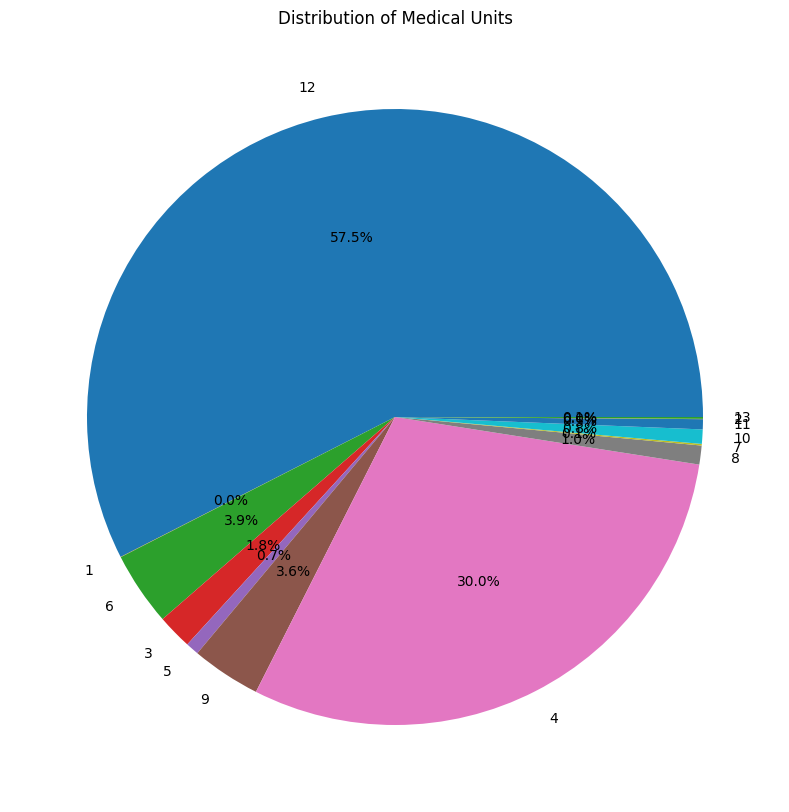

In [18]:
# Show distribute of MEDICAL_UNIT column in pie chart
import matplotlib.pyplot as plt

medical_units_distribution = spark.sql("SELECT MEDICAL_UNIT, COUNT(*) AS count FROM covid GROUP BY MEDICAL_UNIT").toPandas()

plt.figure(figsize=(15, 10))
plt.pie(medical_units_distribution["count"], labels=medical_units_distribution["MEDICAL_UNIT"], autopct="%1.1f%%")

plt.title("Distribution of Medical Units")
plt.show()

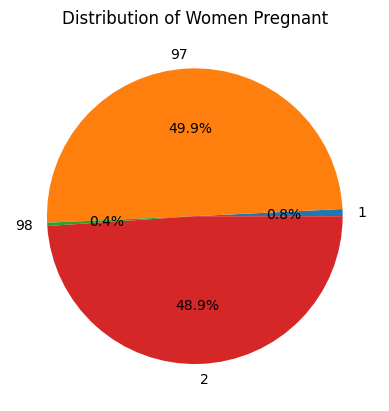

In [19]:
# Show distribution of 'PREGNANT' column in pie chart
import matplotlib.pyplot as plt

pregnant_distribution = spark.sql("SELECT PREGNANT, COUNT(*) as Count FROM covid GROUP BY PREGNANT").toPandas()

plt.pie(pregnant_distribution["Count"], labels=pregnant_distribution["PREGNANT"], autopct="%1.1f%%")
plt.title("Distribution of Women Pregnant")
plt.show()

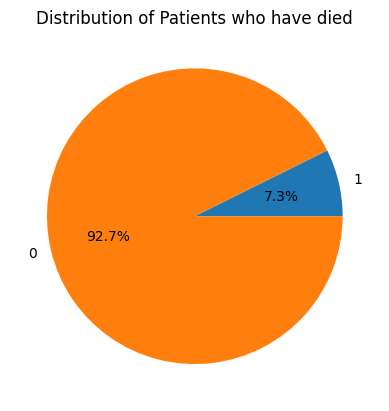

In [57]:
# Show distribution of 'hasDied' column in pie chart
import matplotlib.pyplot as plt

died_distribution = spark.sql("SELECT hasDied, COUNT(*) as Count FROM covid GROUP BY hasDied").toPandas()

plt.pie(died_distribution["Count"], labels=died_distribution["hasDied"], autopct="%1.1f%%")
plt.title("Distribution of Patients who have died")
plt.show()

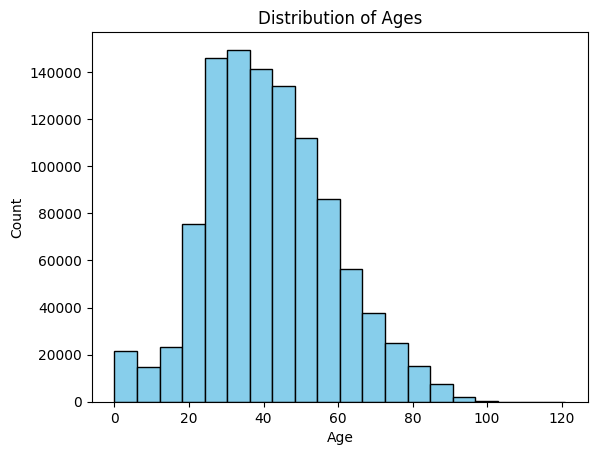

In [21]:
# Show distribution of 'AGE' column in histogram
import matplotlib.pyplot as plt

age_distribution = spark.sql("SELECT AGE FROM covid").toPandas()

plt.hist(age_distribution["AGE"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

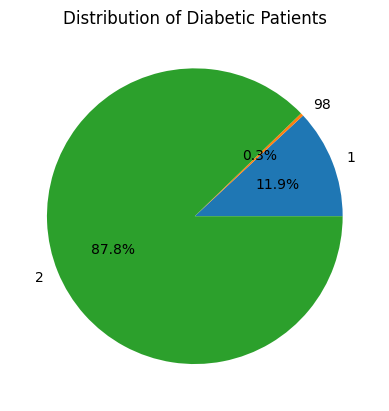

In [22]:
# Show distribution of 'DIABETES' column in pie chart
import matplotlib.pyplot as plt

diabetes_distribution = spark.sql("SELECT DIABETES, COUNT(*) as Count FROM covid GROUP BY DIABETES").toPandas()

plt.pie(diabetes_distribution["Count"], labels=diabetes_distribution["DIABETES"], autopct="%1.1f%%")
plt.title("Distribution of Diabetic Patients")
plt.show()

In [23]:
# count, mean, standard deviation, min, and max .
df.describe().show()

+-------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+--------------------+-----------------+-------------------+
|summary|             USMER|      MEDICAL_UNIT|                SEX|      PATIENT_TYPE|          INTUBED|         PNEUMONIA|               AGE|         PREGNANT|          DIABETES|              COPD|            ASTHMA|           INMSUPR|      HIPERTENSION|    OTHER_DISEASE|    CARDIOVASCULAR|          OBESITY|     RENAL_CHRONIC|           TOBACCO|CLASIFFICATION_FINAL|              ICU|            hasDied|
+-------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----

In [24]:
#number of rows
df.count()

1048575

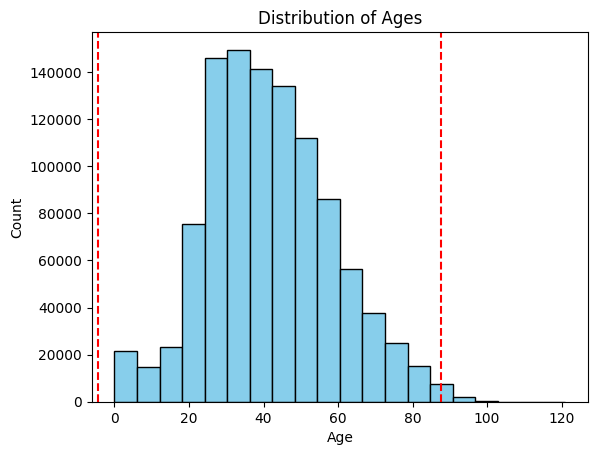

In [56]:
# Find outliers in the 'AGE' column
from pyspark.sql.functions import col

q1, q3 = df.approxQuantile("AGE", [0.25, 0.75], 0)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Show the outliers in a chart

import matplotlib.pyplot as plt

age_distribution = spark.sql("SELECT AGE FROM covid").toPandas()

plt.hist(age_distribution["AGE"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Ages")
plt.xlabel("Age")
plt.ylabel("Count")

plt.axvline(lower_bound, color="red", linestyle="--")
plt.axvline(upper_bound, color="red", linestyle="--")

plt.show()

In [25]:
 #number of nulls in the column
from pyspark.sql.functions import col, when, count
null_counts = []
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    null_counts.append((column, null_count))

print('Column/Null Count')
for column, count in null_counts:
    print(f"{column}:{count}")

Column/Null Count
USMER:0
MEDICAL_UNIT:0
SEX:0
PATIENT_TYPE:0
INTUBED:0
PNEUMONIA:0
AGE:0
PREGNANT:0
DIABETES:0
COPD:0
ASTHMA:0
INMSUPR:0
HIPERTENSION:0
OTHER_DISEASE:0
CARDIOVASCULAR:0
OBESITY:0
RENAL_CHRONIC:0
TOBACCO:0
CLASIFFICATION_FINAL:0
ICU:0
hasDied:0


In [26]:
# range and distribution in each feature to discover imbalances
for col in df.columns:
    df.groupBy(col).count().show()

+-----+------+
|USMER| count|
+-----+------+
|    1|385672|
|    2|662903|
+-----+------+

+------------+------+
|MEDICAL_UNIT| count|
+------------+------+
|          12|602995|
|           1|   151|
|           6| 40584|
|           3| 19175|
|           5|  7244|
|           9| 38116|
|           4|314405|
|           8| 10399|
|           7|   891|
|          10|  7873|
|          11|  5577|
|           2|   169|
|          13|   996|
+------------+------+

+---+------+
|SEX| count|
+---+------+
|  1|525064|
|  2|523511|
+---+------+

+------------+------+
|PATIENT_TYPE| count|
+------------+------+
|           1|848544|
|           2|200031|
+------------+------+

+-------+------+
|INTUBED| count|
+-------+------+
|      1| 33656|
|     97|848544|
|      2|159050|
|     99|  7325|
+-------+------+

+---------+------+
|PNEUMONIA| count|
+---------+------+
|        1|140038|
|        2|892534|
|       99| 16003|
+---------+------+

+---+-----+
|AGE|count|
+---+-----+
| 31|25927|
| 8

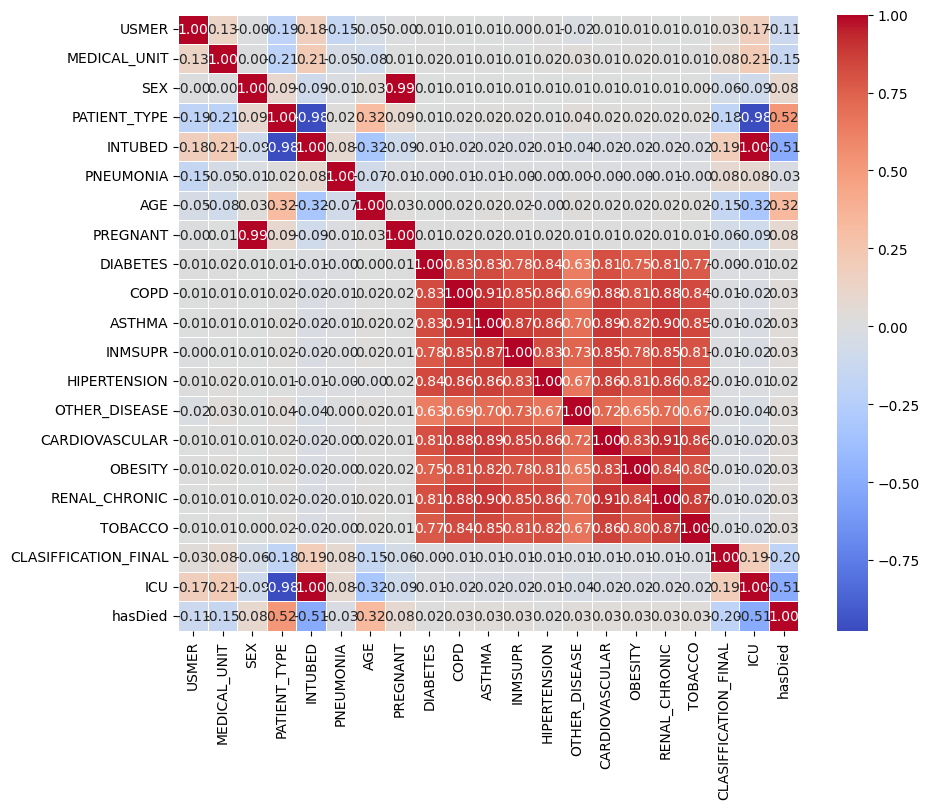

In [27]:
# correlation matrix helps us see which features are affected by each other and which have an influence on the hasDied
import seaborn as sns
import matplotlib.pyplot as plt
df_pandas = df.toPandas()
df_numerical = df_pandas.select_dtypes(include=['number'])
corrmatrix = df_numerical.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corrmatrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

#### Notes about Correlation Matrix:
The higher the patient's type then the more likely of the patient is or was in ICU. There is a perfect positive correlation where patients that are Intubed are in ICU. Intubed has the highest positive correlation with hasDied. There is a large box in the middle of the correlation matrix where several of the patients diseases are positively correlated with each other. From this information, we can assume that if a pateint has any of these diseases the are likely to have the others.

#### Conclusion from Data Exploration:
The target column 'hasDied' has a very imbalanced distribution. This discovery means we must consider models that can handle imbalances. Those options could be tree-based models, while Logistic Regression and Support Vector Machines can be used with editing the class weights or resampling.

# Machine Learning Algorithm Preparation and Tuning

## Setting Up a Random Forest Classifier

In [73]:
# Setup a tree-based model to predict the 'hasDied' column
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

features = [col for col in df.columns if col not in ["hasDied"]]

# Create a vector assembler
# The input columns are all columns except 'hasDied'
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Create a random forest classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="hasDied")

# Create a pipeline
rf_pipeline = Pipeline(stages=[assembler, rf])

# Split the data into training and testing sets
train, test = df.randomSplit([0.7, 0.3])

# Fit the model
rf_model = rf_pipeline.fit(train)

# Make predictions
rf_predictions = rf_model.transform(test)

## Setting Up a Logistic Regression Model

In [ ]:
# Setup a logistic regression model to predict the 'hasDied' column
from pyspark.ml.classification import LogisticRegression

# Create a logistic regression classifier
lr = LogisticRegression(featuresCol="features", labelCol="hasDied")

# Create a pipeline
lr_pipeline = Pipeline(stages=[assembler, lr])

# Fit the model
lr_model = lr_pipeline.fit(train)

# Make predictions
lr_predictions = lr_model.transform(test)

Logistic Regression Accuracy: 0.9357229381074559


# Model Evaluation and Visualization

## Random Forest Evaluation and Visuals

In [ ]:
# Show the accuracy of the model with *binary* classification evaluator
# since we are trying to predict if a patient has died or not (binary classification).
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf_evaluator = BinaryClassificationEvaluator(labelCol="hasDied")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)

print(f"Accuracy: {rf_accuracy}")

Accuracy: 0.9563684982409018


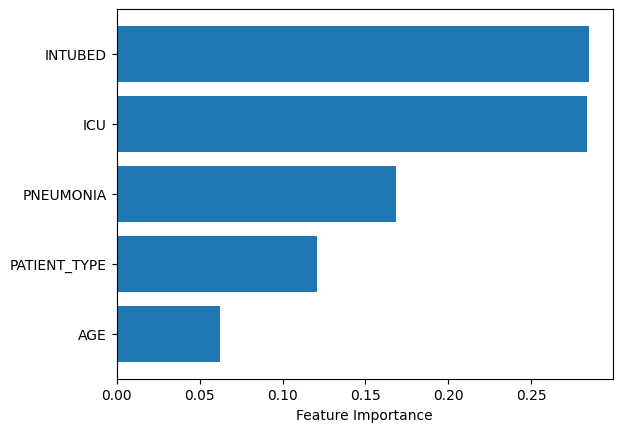

In [ ]:
# Show the top 5 feature importances in a chart
import matplotlib.pyplot as plt

rf_model_stages = rf_model.stages[-1]
rf_feature_importances = rf_model_stages.featureImportances

rf_importances = rf_feature_importances.toArray()
rf_indices = rf_importances.argsort()[-5:]

plt.barh(range(len(rf_indices)), rf_importances[rf_indices])
plt.yticks(range(len(rf_indices)), [features[i] for i in rf_indices])
plt.xlabel("Feature Importance")
plt.show()

In [ ]:
# Cross-validation for Random Forest Classifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

param_grid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 30]).build()

crossval = CrossValidator(estimator=rf_pipeline, estimatorParamMaps=param_grid, evaluator=rf_evaluator, numFolds=3)

cv_model = crossval.fit(train)

cv_predictions = cv_model.transform(test)

cv_accuracy = rf_evaluator.evaluate(cv_predictions)

print(f"Accuracy: {cv_accuracy}")

Accuracy: 0.9557455523083425


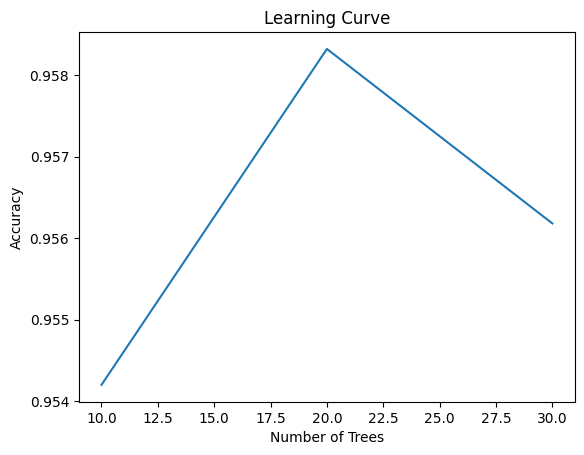

In [ ]:
# Show chart of the learning curve
import matplotlib.pyplot as plt

cv_models = cv_model.avgMetrics

plt.plot([10, 20, 30], cv_models)
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.show()

### Conclusion on the learning curve

The Random Forest Model had the best accuracy using 20 trees within its algorithm, which is the default number of trees, for predicting whether a patient is at risk of dieing.

## Logistic Regression Model Evaluation and Visuals

In [84]:
# Evaluate the logistic regression model's accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create an evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="hasDied", metricName="accuracy")

# Evaluate the model
lr_accuracy = evaluator.evaluate(lr_predictions)

print(f"Logistic Regression Accuracy: {lr_accuracy}")

Logistic Regression Accuracy: 0.9357229381074559


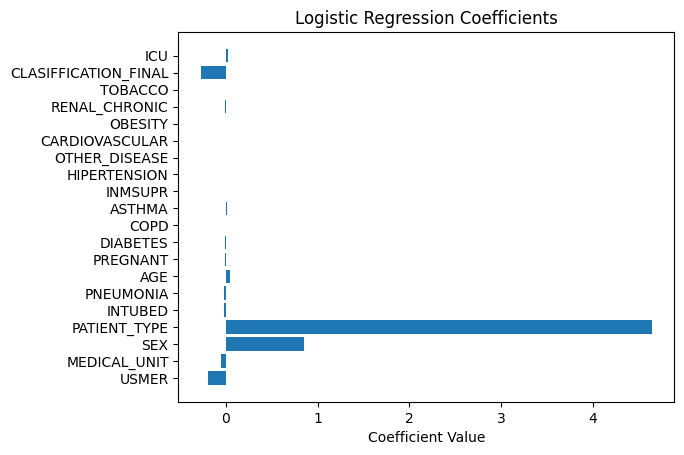

In [85]:
# Show the coefficients of the logistic regression model
lr_model_stages = lr_model.stages[-1]
lr_coefficients = lr_model_stages.coefficients.toArray()

plt.barh(range(len(lr_coefficients)), lr_coefficients)
plt.yticks(range(len(lr_coefficients)), features)
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Coefficients")
plt.show()

In [86]:
# Cross-validation for Logistic Regression
param_grid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01, 0.001]).build()

crossval = CrossValidator(estimator=lr_pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

cv_model = crossval.fit(train)

cv_predictions = cv_model.transform(test)

cv_accuracy = evaluator.evaluate(cv_predictions)

print(f"Logistic Regression Accuracy: {cv_accuracy}")

Logistic Regression Accuracy: 0.9352396758327531


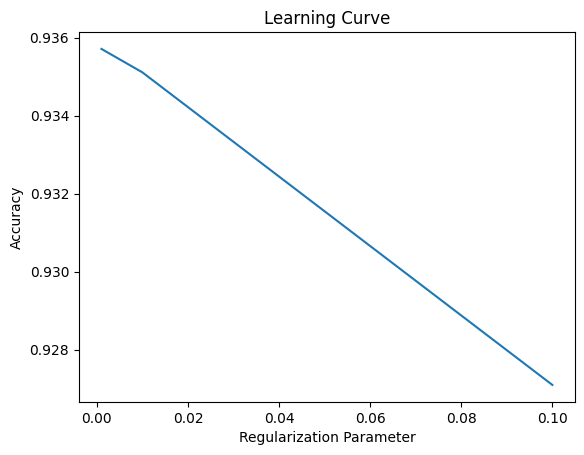

In [87]:
# Show chart of the learning curve
cv_models = cv_model.avgMetrics

plt.plot([0.1, 0.01, 0.001], cv_models)

plt.xlabel("Regularization Parameter")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.show()

# Limitations, Future Work, and Conclusion

## Conclusion

(TODO: Talk about which model performed the best and potiently why, if we know.)

In [ ]:
# Close the Spark session

spark.stop()